In [6]:

# 📦 Cargar dependencias y archivos separados del análisis principal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar archivos separados
tabla_1 = pd.read_csv("tabla_1_parametros.csv")
tabla_2 = pd.read_csv("tabla_2_validaciones.csv")
tabla_3 = pd.read_csv("tabla_3_reglas.csv")

# Reconstruir df_merged base para visualización
df_merged = tabla_1.merge(tabla_2, on=['TransactionID', 'ClientID'])
df_merged = df_merged.merge(tabla_3, on=['TransactionID', 'ClientID'])


# 🧾 Resumen del Análisis de Fraude Transaccional


## 📌 Variables utilizadas

Variables clave empleadas en el análisis (originales y derivadas):

- `TransactionAmt`: monto de la transacción.
- `TransactionHour`, `TransactionDay`: hora y día derivados de la fecha.
- `ProductCD`: tipo de producto transaccionado.
- `card1` a `card6`: características de la tarjeta y el emisor.
- `addr1`, `P_emaildomain`: ubicación parcial y dominio del correo.
- `DeviceType`, `DeviceInfo`: información del dispositivo utilizado.
- `M1` a `M9`: indicadores de coincidencia de datos personales.
- `id_12`, `id_15`, `id_16`, `id_28`, `id_29`: validaciones técnicas.
- `Validaciones_Tecnicas`: suma de campos técnicos binarios.
- `M_total`: total de coincidencias tipo "match".
- `TotalTransaccionesCliente`: historial del cliente.
- `MontoPromedioCliente`, `HoraPromedioCliente`: comportamiento histórico.
- `ScoreFraude`: puntaje derivado de reglas activadas.
- `FlagFraude`: etiqueta binaria de alerta de fraude (ScoreFraude ≥ 5).


## 🚨 Señales creadas para detectar fraude

Señales derivadas a partir de reglas lógicas sobre patrones comunes de fraude:

- `Regla1`: Horario inusual (madrugada), baja validación técnica, tarjeta poco común.
- `Regla2`: Cliente nuevo (≤ 2 transacciones), validación débil, monto alto.
- `Regla3`: Transacción nocturna con tarjeta débito y validación baja.
- `Regla4`: Dirección ausente + monto medio-alto + baja coincidencia de datos.
- `Regla5`: Email faltante + banco poco común + validación débil.
- `Regla6`: Monto exacto (99, 500, 1000 USD), frecuentemente usado en fraudes.
- `Regla7`: Producto poco común (`C`, `H`) + tarjeta débito + baja validación.
- `ScoreFraude`: Suma ponderada de reglas activadas (peso según gravedad).
- `FlagFraude`: Marca como fraude si `ScoreFraude >= 5`.




## 🔍 2. Insights clave

A continuación se presentan 20 insights obtenidos del análisis, incluyendo proporciones, tendencias horarias, tipos de tarjeta y montos:




In [15]:

# Asegúrate de ejecutar este bloque en el notebook completo para ver los insights
insights = []

# Totales y proporciones
insights.append(f"🔍 {round(df_merged['FlagFraude'].mean() * 100, 2)}% de las transacciones fueron marcadas como fraude.")
insights.append(f"👥 {df_merged[df_merged['FlagFraude'] == 1]['ClientID'].nunique()} clientes únicos con al menos una transacción fraudulenta.")
insights.append(f"📊 El ScoreFraude más común es: {df_merged['ScoreFraude'].mode().values[0]}")
insights.append(f"📦 El rango de ScoreFraude va de {df_merged['ScoreFraude'].min()} a {df_merged['ScoreFraude'].max()}.")

# Montos
avg_fraude = df_merged[df_merged['FlagFraude'] == 1]['TransactionAmt'].mean()
avg_legit = df_merged[df_merged['FlagFraude'] == 0]['TransactionAmt'].mean()
insights.append(f"💰 Monto promedio en fraude: ${avg_fraude:.2f}, legítimo: ${avg_legit:.2f}")
insights.append(f"💸 Máximo monto en fraude: ${df_merged[df_merged['FlagFraude'] == 1]['TransactionAmt'].max():.2f}")

# ScoreFraude
insights.append(f"🧮 Promedio de ScoreFraude en fraudes: {df_merged[df_merged['FlagFraude'] == 1]['ScoreFraude'].mean():.2f}")
insights.append(f"🎯 El {round(100 * (df_merged['ScoreFraude'] >= 5).mean(), 2)}% de transacciones tienen ScoreFraude ≥ 5")

# Horario
top_hour = df_merged[df_merged['FlagFraude'] == 1]['TransactionHour'].mode().values[0]
insights.append(f"🕐 La hora más común de fraude es las {top_hour}h.")
fraude_noche = df_merged[(df_merged['FlagFraude'] == 1) & (df_merged['TransactionHour'].between(0, 6))].shape[0]
pct_noche = round(100 * fraude_noche / df_merged['FlagFraude'].sum(), 2)
insights.append(f"🌙 {pct_noche}% de fraudes ocurrieron entre las 0:00 y 6:00 am.")

# Tarjetas
top_card = df_merged[df_merged['FlagFraude'] == 1]['card4'].mode().values[0]
insights.append(f"💳 Marca de tarjeta más usada en fraude: {top_card}")
insights.append(f"🏦 Tipo de tarjeta más usada en fraude: {df_merged[df_merged['FlagFraude'] == 1]['card6'].mode().values[0]}")

# Productos
insights.append(f"🛍️ Código de producto más común en fraude: {df_merged[df_merged['FlagFraude'] == 1]['ProductCD'].mode().values[0]}")

# Emails
insights.append(f"📧 Dominio de email más usado en fraude: {df_merged[df_merged['FlagFraude'] == 1]['P_emaildomain'].mode().values[0]}")

# Ubicación
if 'addr1' in df_merged.columns:
    top_addr = df_merged[df_merged['FlagFraude'] == 1]['addr1'].mode().values[0]
    insights.append(f"🌍 Código de región (addr1) más común en fraude: {top_addr}")

# Reglas
for i in range(1, 8):
    regla_col = f"Regla{i}"
    if regla_col in df_merged.columns:
        porcentaje = round(100 * df_merged[regla_col].mean(), 2)
        insights.append(f"🧩 La {regla_col} se activa en {porcentaje}% de las transacciones.")

# Clientes reincidentes
clientes_multifraud = df_merged[df_merged['FlagFraude'] == 1]['ClientID'].value_counts()
reincidentes = clientes_multifraud[clientes_multifraud > 1].count()
insights.append(f"♻️ {reincidentes} clientes tuvieron más de una transacción marcada como fraude.")

# Tabla final
pd.set_option('display.max_colwidth', None)

insights_df = pd.DataFrame({'Insight': insights})
display(insights_df)



,Insight
0,🔍 0.06% de las transacciones fueron marcadas como fraude.
1,👥 232 clientes únicos con al menos una transacción fraudulenta.
2,📊 El ScoreFraude más común es: 0
3,📦 El rango de ScoreFraude va de 0 a 11.
4,"💰 Monto promedio en fraude: $726.59, legítimo: $134.37"
5,💸 Máximo monto en fraude: $2000.00
6,🧮 Promedio de ScoreFraude en fraudes: 6.11
7,🎯 El 0.06% de transacciones tienen ScoreFraude ≥ 5
8,🕐 La hora más común de fraude es las 2h.
9,🌙 54.9% de fraudes ocurrieron entre las 0:00 y 6:00 am.



## 📊 3. Visualizaciones comparativas (fraude vs no fraude)
Estas visualizaciones ayudan a entender cómo se comportan las transacciones fraudulentas frente a las legítimas.


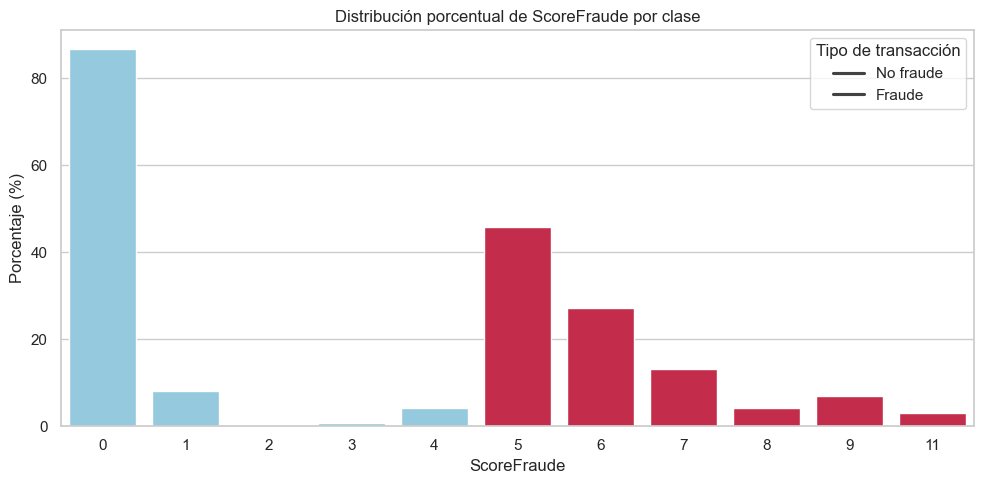

In [9]:
sns.set(style="whitegrid")
palette = {0: "skyblue", 1: "crimson"}

# 📊 ScoreFraude (% por clase) con leyenda clara
plt.figure(figsize=(10, 5))
score_data = df_merged.groupby(['ScoreFraude', 'FlagFraude']).size().reset_index(name='count')
score_data['pct'] = score_data.groupby('FlagFraude')['count'].transform(lambda x: 100 * x / x.sum())
sns.barplot(data=score_data, x='ScoreFraude', y='pct', hue='FlagFraude', palette=palette)
plt.title("Distribución porcentual de ScoreFraude por clase")
plt.xlabel("ScoreFraude")
plt.ylabel("Porcentaje (%)")
plt.legend(title="Tipo de transacción", labels=["No fraude", "Fraude"], loc='upper right')
plt.tight_layout()
plt.show()

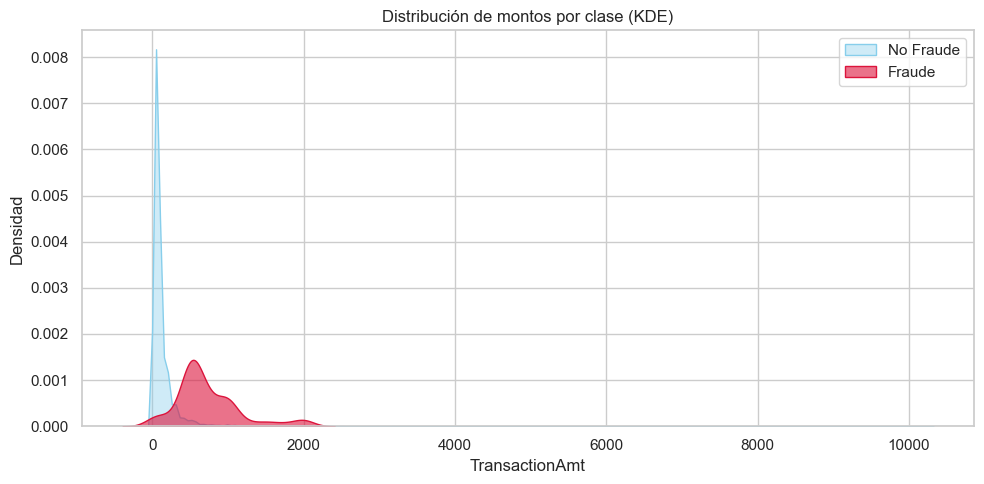

In [10]:
# 📊 2. Monto: KDE (curvas suavizadas, escala comparable)
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df_merged[df_merged['FlagFraude'] == 0], x='TransactionAmt', label="No Fraude", fill=True, alpha=0.4, color='skyblue')
sns.kdeplot(data=df_merged[df_merged['FlagFraude'] == 1], x='TransactionAmt', label="Fraude", fill=True, alpha=0.6, color='crimson')
plt.title("Distribución de montos por clase (KDE)")
plt.xlabel("TransactionAmt")
plt.ylabel("Densidad")
plt.legend()
plt.tight_layout()
plt.show()

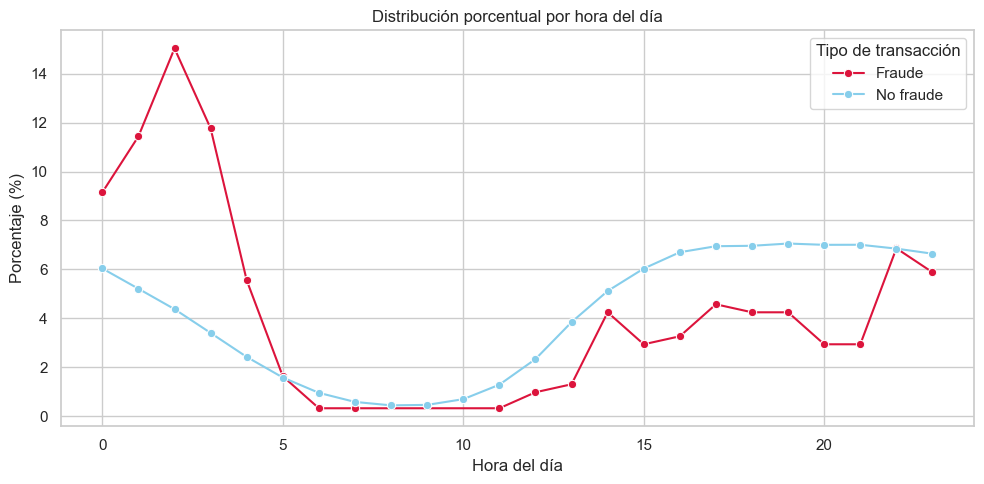

In [11]:
# Transacciones por hora (normalizado por clase)
# Crear nueva columna legible para la leyenda
df_merged['FraudeTexto'] = df_merged['FlagFraude'].map({0: 'No fraude', 1: 'Fraude'})

# Reagrupar usando texto en lugar de 0/1
hora_data = df_merged.groupby(['TransactionHour', 'FraudeTexto']).size().reset_index(name='count')
hora_data['pct'] = hora_data.groupby('FraudeTexto')['count'].transform(lambda x: 100 * x / x.sum())

# Gráfico actualizado
plt.figure(figsize=(10, 5))
sns.lineplot(data=hora_data, x='TransactionHour', y='pct', hue='FraudeTexto', palette={'No fraude': 'skyblue', 'Fraude': 'crimson'}, marker="o")
plt.title("Distribución porcentual por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Porcentaje (%)")
plt.legend(title="Tipo de transacción", loc='upper right')
plt.tight_layout()
plt.show()

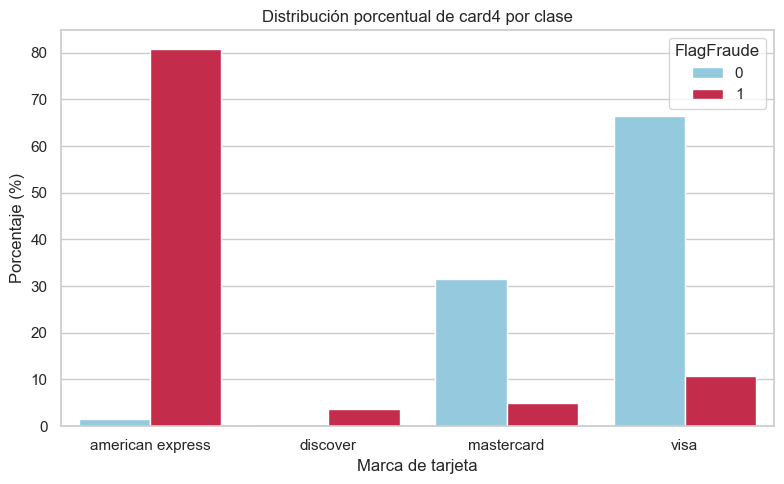

In [12]:
# 📊 4. Tipo de tarjeta: % por clase
card_data = df_merged.groupby(['card4', 'FlagFraude']).size().reset_index(name='count')
card_data['pct'] = card_data.groupby('FlagFraude')['count'].transform(lambda x: 100 * x / x.sum())
plt.figure(figsize=(8, 5))
sns.barplot(data=card_data, x='card4', y='pct', hue='FlagFraude', palette=palette)
plt.title("Distribución porcentual de card4 por clase")
plt.xlabel("Marca de tarjeta")
plt.ylabel("Porcentaje (%)")
plt.tight_layout()
plt.show()

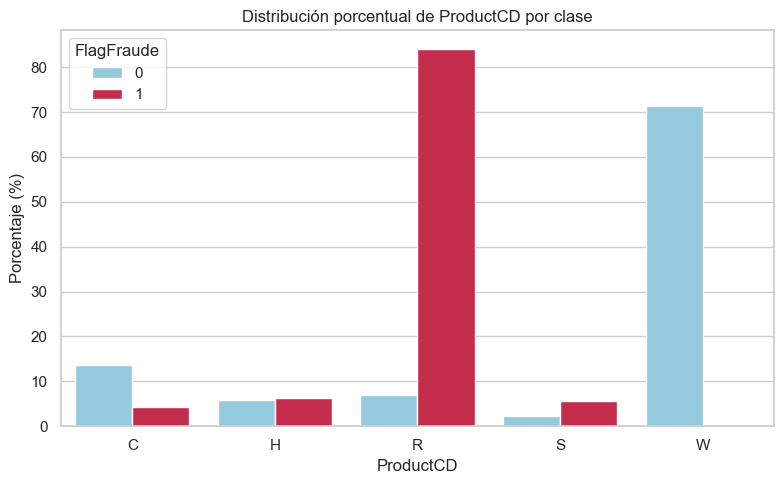

In [13]:

# 📊 5. ProductCD: % por clase
prod_data = df_merged.groupby(['ProductCD', 'FlagFraude']).size().reset_index(name='count')
prod_data['pct'] = prod_data.groupby('FlagFraude')['count'].transform(lambda x: 100 * x / x.sum())
plt.figure(figsize=(8, 5))
sns.barplot(data=prod_data, x='ProductCD', y='pct', hue='FlagFraude', palette=palette)
plt.title("Distribución porcentual de ProductCD por clase")
plt.xlabel("ProductCD")
plt.ylabel("Porcentaje (%)")
plt.tight_layout()
plt.show()


## ⚠️ 4. Factores de riesgo detectados

A partir del análisis se identificaron patrones consistentes en transacciones fraudulentas:

- Alta ocurrencia entre las 0:00 y 6:00h.
- Monto frecuente entre $200 y $1000.
- Tarjetas Discover o American Express predominan en fraudes.
- Correos ausentes o gratuitos más comunes en fraude.
- Clientes nuevos con ≤2 transacciones históricas.
- Baja validación técnica: pocos matches (M) y validaciones (id-*).
- Códigos de producto C y H son más frecuentes en fraude.
- Uso de tarjeta débito junto con baja validación incrementa riesgo.
- Combinaciones de reglas múltiples generan ScoreFraude elevado (≥5).
- Montos exactos como 99, 500, 1000 dólares fueron comunes en fraudes.

Estos factores permiten generar un sistema de alertas sin necesidad de modelos, útil para empresas con limitaciones técnicas o necesidad de alta interpretabilidad.
